In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [58]:
url='/content/drive/MyDrive/Churn_Modelling.csv'

df=pd.read_csv(url)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [59]:
df.shape

(10000, 14)

**Data Preprocessing**

In [60]:
df=df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [61]:
df.shape

(10000, 11)

In [62]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [63]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


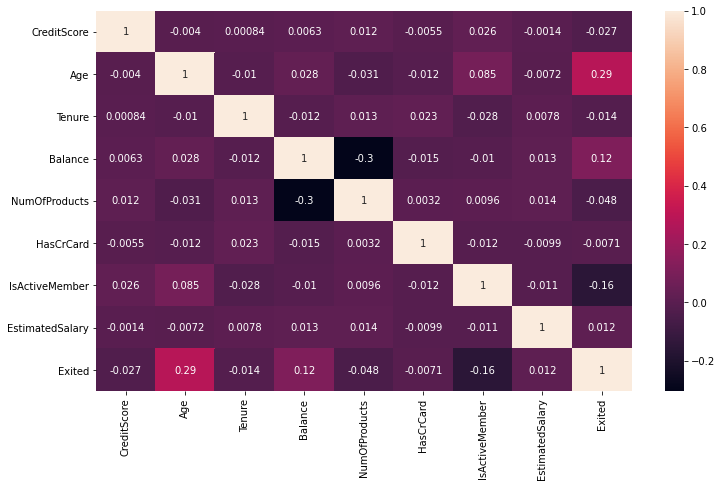

In [64]:
plt.figure(figsize=(12,7))
corrMat=df.corr()
sns.heatmap(corrMat, annot=True)
plt.show()

In [65]:
#Create dummy variables

geography=pd.get_dummies(df["Geography"],drop_first=True)
gender=pd.get_dummies(df['Gender'],drop_first=True)

In [66]:
# Concatenate the Data Frames

df=pd.concat([df,geography,gender],axis=1)

# Drop Unnecessary columns
df=df.drop(['Geography','Gender'],axis=1)

In [67]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [68]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [69]:
# Dividing dependent and independent variables

X=df.drop('Exited',axis=1)
y=df['Exited']


In [70]:
# Sampling

from imblearn.over_sampling import SMOTE 
from collections import Counter

sampler = SMOTE()
X_res, y_res = sampler.fit_sample(X, y)

print('SMOTE {}'.format(Counter(y_res)))

SMOTE Counter({1: 7963, 0: 7963})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [71]:
# Splitting a dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_res, y_res, test_size=0.25, random_state=42)


In [72]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Hyperparameter**

In [73]:
!pip install -q -U keras-tuner

In [74]:
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.layers import Dense, Activation,  Dropout
from keras.activations import relu, sigmoid


In [75]:
def build_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            
    model.add(Dense(1)) 
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model
    
model = KerasClassifier(build_fn=build_model, verbose=0)

In [76]:
layers = [(40, 20), (45, 30, 15), (60,40,25,10),(80,60,40,25,10)]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=5)

In [77]:
grid_result = grid.fit(X_train, y_train)

In [78]:
grid_result

GridSearchCV(cv=5, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f44b9a95f90>,
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['sigmoid', 'relu'],
                         'batch_size': [128, 256], 'epochs': [30],
                         'layers': [(40, 20), (45, 30, 15), (60, 40, 25, 10),
                                    (80, 60, 40, 25, 10)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
[grid_result.best_score_,grid_result.best_params_]

[0.8297894120216369,
 {'activation': 'relu',
  'batch_size': 128,
  'epochs': 30,
  'layers': (80, 60, 40, 25, 10)}]

In [80]:
result=grid.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [81]:
y_pred=(result>0.5)

In [82]:
from sklearn.metrics import confusion_matrix,accuracy_score

score=accuracy_score(y_test,y_pred)
print(f'Accuracy of the model is {score*100}%')

Accuracy of the model is 83.82722250125565%


In [83]:
confusion_m=confusion_matrix(y_test,y_pred )
confusion_m

array([[1716,  320],
       [ 324, 1622]])

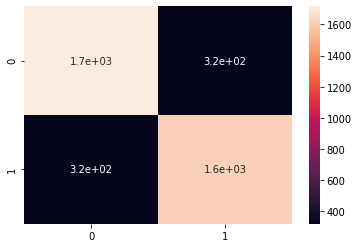

In [84]:
sns.heatmap(confusion_m, annot=True)